In [1]:
%pylab inline
import emcee
import programas as pg

Populating the interactive namespace from numpy and matplotlib


## voy a probar fitear el modelo de la suma de perfiles.
#### comienzo con un modelo de solo dos parametros (delta y delta^2)

$\delta_g(r) = b_1·delta_m(r) + b_2·(\delta_m(r)^2 - <\delta_m(r)^2>)$

In [2]:
f1_file = np.load('f1_perfiles.npy')
f2_file = np.load('f2_perfiles.npy')
f4_file = np.load('f4_perfiles.npy')


f1 = f1_file[:,1:]
f2 = f2_file[:,1:]
f4 = f4_file[:,1:]

In [3]:
# calculo medias y errores de los perfiles

realizaciones = 10

mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
mean_4, error_4 = pg.perfil_jack(f4,realizaciones)

<ErrorbarContainer object of 3 artists>

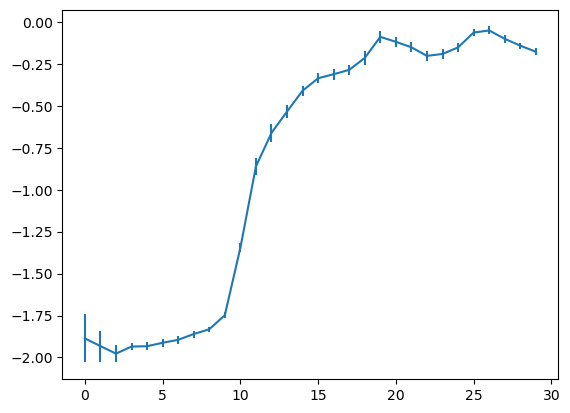

In [4]:
# comienzo definiendo el "modelo perfecto"
b1 = 1.13
b2 = 0.55
b4 = -1.3

# el modelo que quiero ajustar es entonces:
f0 = b1*mean_1 + b2*mean_2 + b4*mean_4

# y le invento errores de la DM (error_1)

error_0 = 3 * error_1

plt.errorbar(np.arange(30),f0, error_0)

In [5]:
def model(theta,d1,d2,d4):
    b1 = theta[0]
    b2 = theta[1]
    b4 = theta[2]
    perfil = b1*d1 + b2*d2 + b4*d4
    return perfil

In [6]:
# this funcion return a number corresponding to how good a fit your model is to your data 
# for a given set of parameters, weighted by the error in your data points.

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

In [7]:
# this functions checks if the parameters are in the range of the priors

priors1 = [0.5,2.5]
priors2 = [0,1]
priors4 = [-2,0]

def lnprior(theta):
    b1, b2, b4 = theta
    if priors1[0] < b1 < priors1[1] and priors2[0] < b2 < priors2[1] and priors4[0] < b4 < priors4[1]:
        return 0.0
    return -np.inf

In [8]:
# esta funcion calcula el lnlike (ve el fit del ajuste) si los parametros estan dentro de los priors
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [9]:
# Datos de ejemplo
F_obs = f0  # Datos observados
sigma_F_obs = error_0
F1 = mean_1  # Perfil F1
F2 = mean_2  # Perfil F2
F4 = mean_4

# Supongamos que los errores son independientes
C = np.diag(sigma_F_obs**2)

In [10]:
# Función de verosimilitud
def log_likelihood(params, F_obs, F1, F2, F4, C_inv):
    b1, b2, b4 = params
    model = b1 * F1 + b2 * F2 + b4*F4
    diff = F_obs - model
    return -0.5 * np.dot(diff, np.dot(C_inv, diff))

# Priors
def log_prior(params):
    b1, b2, b4 = params
    if -2 < b1 < 4 and -1 < b2 < 2 and -4 < b4 < 3:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, F_obs, F1, F2, F4, C_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, F_obs, F1, F2, F4, C_inv)

In [11]:
# Inverso de la matriz de covarianza
C_inv = np.linalg.inv(C)

# Configuración de MCMC
ndim = 3  # Número de parámetros
nwalkers = 50  # Número de walkers
nsteps = 1000  # Número de pasos

In [12]:
# Inicializar walkers aleatoriamente
starting_guesses = np.random.rand(nwalkers, ndim)

In [13]:
# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F1, F2, F4, C_inv))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 572.37it/s]


State([[ 1.05889872  0.56438144 -0.31594303]
 [ 1.06037112  0.55816461 -2.50054464]
 [ 1.17571205  0.54217205 -1.14441626]
 [ 1.17849828  0.53538074 -2.34866286]
 [ 1.31374793  0.51251147 -3.84300289]
 [ 1.08585635  0.55827347 -2.76538223]
 [ 1.18169575  0.53907555 -2.31311009]
 [ 1.18975916  0.53976252 -1.16426467]
 [ 1.28328545  0.52666011  0.47776216]
 [ 0.94038528  0.58454652  1.75651846]
 [ 1.12307568  0.55565712  0.13026219]
 [ 1.33237938  0.51100853 -2.88043291]
 [ 1.10790484  0.55493669  1.17172102]
 [ 1.11286196  0.54970342 -3.22197449]
 [ 0.85027761  0.60842608  1.7984759 ]
 [ 1.27401574  0.52661109 -2.31908354]
 [ 1.18127931  0.53913784 -3.42607431]
 [ 1.02648824  0.56935393  0.14139857]
 [ 1.48064249  0.48652416 -0.96980639]
 [ 1.18220804  0.53556221 -1.0028609 ]
 [ 1.01327036  0.57607203 -1.6861444 ]
 [ 1.29709996  0.51724341 -2.74415732]
 [ 1.28849538  0.5220383   0.27455948]
 [ 1.05874321  0.564758   -2.35367001]
 [ 1.014808    0.57711843  0.19284313]
 [ 1.00725007  0.57

In [14]:
# Análisis de resultados
samples = sampler.get_chain(discard=100, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
b1_samples, b2_samples, b4_samples = samples[:, 0], samples[:, 1], samples[:,2]

In [15]:
# Calcular medias y desviaciones estándar
b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)

print(f"b1 = {b1_mean} ± {b1_std}")
print(f"b2 = {b2_mean} ± {b2_std}")
print(f"b2 = {b4_mean} ± {b4_std}")

b1 = 1.1252736392722216 ± 0.12714830338786695
b2 = 0.5512602323096985 ± 0.024826383973935592
b2 = -1.0029563891996598 ± 1.6338913110267446


Text(0, 0.5, '$\\theta_2$')

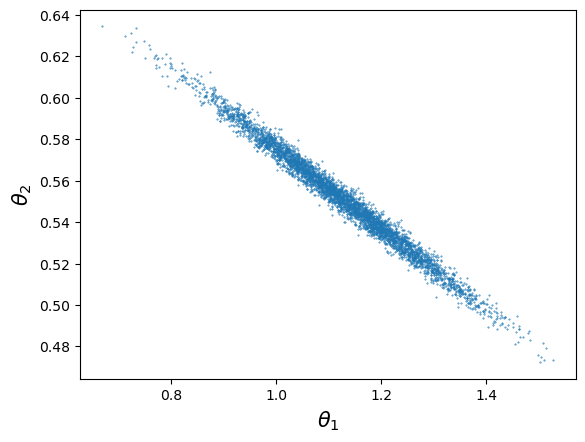

In [16]:
plt.plot(b1_samples,b2_samples,ls='none',marker='o',markersize=.4)
plt.xlabel('$\\theta_1$',size=15)
plt.ylabel('$\\theta_2$',size=15)

## Ahora voy a intentar ajustar el modelo al perfil real

In [17]:
f1_file = np.load('f1_perfiles.npy')
f2_file = np.load('f2_perfiles.npy')
f4_file = np.load('f4_perfiles.npy')

f1 = f1_file[:,1:]
f2 = f2_file[:,1:]
f4 = f4_file[:,1:]

realizaciones = 80

mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
mean_4, error_4 = pg.perfil_jack(f4,realizaciones)

In [18]:
original = np.load('original_perfiles.npy')
f0 = original[:,1:]
mean_0, error_0 = pg.perfil_jack(f0,realizaciones)

### calculo su matriz de covarianza como:

$ C_{ij} = \frac{n-1}{n}·\sum_{k=1}^n (\xi_k-\hat{\xi})_i·(\xi_k - \hat{\xi})_j $

In [19]:
def perfil_jack(perfiles,realizaciones):
    # calcula el perfil con error jacknife y matriz
    # de covarianza 
    voidnumber = perfiles.shape[0]
    voidbines = perfiles.shape[1]
    ndivision = int(voidnumber/realizaciones)

    perfiles_jack = np.zeros([realizaciones,voidbines])
    
    total_ids = np.arange(0,voidnumber)

    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
    
    # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        perfiles_jack[i,:] = pg.mean_profile(perfiles[selection,:].T)
        
        exclude0 = exclude1
        
    perfiles_mean = np.zeros(voidbines)
    perfiles_error = np.zeros(voidbines)

    n = realizaciones
    for i in range(voidbines):
        media = np.mean(perfiles_jack[:,i])
        error = np.sqrt(((n-1)/n) * np.sum((perfiles_jack[:,i]-media)**2))
    
        perfiles_mean[i]  = media
        perfiles_error[i] = error
        
    return perfiles_mean, perfiles_error, perfiles_jack

In [20]:
# IMPORTANTE: numero de jacknife tiene que ser mayor que el numero de bines (sino no puede invertirse)
realizaciones = 80
mean_0, error_0, all_0 = perfil_jack(f0,realizaciones)

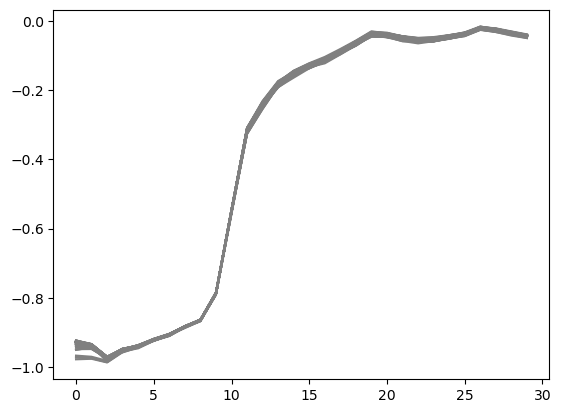

In [21]:
for i in range(all_0.shape[0]):
    plt.plot(all_0[i,:],color='grey')

## Covariance Matrix
$ C_{ij} = \frac{n-1}{n}·\sum_{k=1}^n (\xi_k-\hat{\xi})_i·(\xi_k - \hat{\xi})_j $

que se normaliza como:

$ C_{ij}/\sqrt(C_{ii}C_{jj}) $

In [22]:
def covariance_mat(pmean, pall):
    
    njack  = all_0.shape[0]
    nbines = all_0.shape[1]
    C = np.zeros([nbines,nbines])
    
    for i in range(nbines):
        dif_pi = pall[:,i] - pmean[i]
        
        for j in range(nbines):
            dif_pj = pall[:,j] - pmean[j]
            
            C[i,j] = np.sum(dif_pi*dif_pj)
            
    C = ((njack-1)/njack)*C        
    return C

In [23]:
C = covariance_mat(mean_0,all_0)

# normalization:
ies = C.shape[0]
jes = C.shape[1]

C_new = np.zeros([ies,jes])

for i in range(ies):
    for j in range(jes):
        
        C_new[i,j] = C[i,j]/np.sqrt(C[i,i]*C[j,j])
        
C = C_new

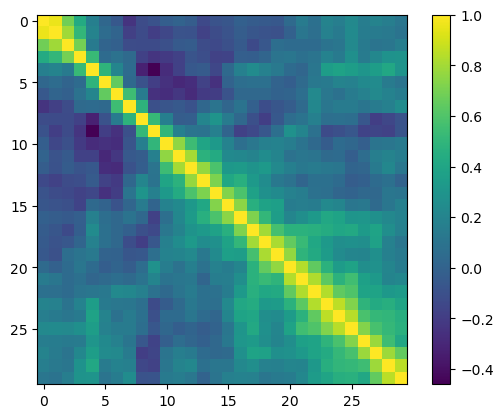

In [24]:
plt.imshow(C_new)
plt.colorbar()

In [25]:
F_obs = mean_0
F1 = mean_1
F2 = mean_2
F4 = mean_4


# Inverso de la matriz de covarianza
C_inv = np.linalg.inv(C)

# Configuración de MCMC
ndim = 3  # Número de parámetros
nwalkers = 50  # Número de walkers
nsteps = 1000  # Número de pasos

# Inicializar walkers aleatoriamente
starting_guesses = np.random.rand(nwalkers, ndim)

# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F1, F2, F4, C_inv))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 498.64it/s]


State([[ 3.92756364 -0.27232074  1.8768319 ]
 [ 1.78393912  0.09604499 -3.02756334]
 [ 1.45876664  0.14461257  0.64712763]
 [-1.69927112  0.59486754 -1.09631944]
 [ 0.07465738  0.39815546 -0.4944919 ]
 [ 1.55901641 -0.11831494 -2.80280976]
 [-0.15103919  0.40633098  1.23183588]
 [-0.11806103  0.53431037 -3.5305151 ]
 [ 3.18757561 -0.36017185 -0.84845749]
 [ 3.85583749 -0.42592918  2.22474997]
 [ 3.58909306 -0.43220721  1.62209768]
 [ 3.7105929  -0.56272615 -3.77562892]
 [ 1.51892254  0.16050445  1.53016415]
 [ 3.03832079 -0.28863476 -3.58057026]
 [-1.60092556  0.83735383 -1.00628566]
 [ 3.88592324 -0.56761441 -2.51366898]
 [ 1.53174342  0.11009428  1.55381626]
 [ 1.92621202  0.24111602  2.40715367]
 [-1.32206914  0.63114283  2.60638816]
 [-0.811972    0.6151758   1.5204877 ]
 [ 1.41566481  0.15352587 -0.38179258]
 [-1.34225846  0.52720612  2.62856321]
 [ 0.22627165  0.07357924 -3.21352658]
 [ 3.59726628 -0.30126067 -2.29222637]
 [ 2.26311769 -0.18511698  2.44338514]
 [ 0.25704162  0.39

In [26]:
# Análisis de resultados
samples = sampler.get_chain(discard=100, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
b1_samples, b2_samples, b4_smaples = samples[:, 0], samples[:, 1], samples[:,2]

b1 = 1.058848841113682 ± 1.7055743177230656
b2 = 0.15426919673332734 ± 0.33977288212257023
b2 = -1.0029563891996598 ± 1.6338913110267446


Text(0, 0.5, '$\\theta_2$')

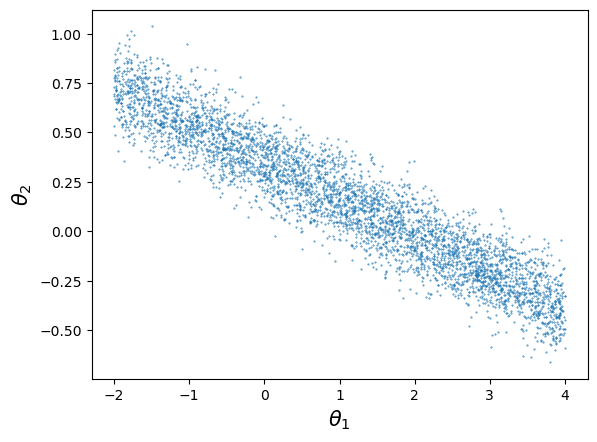

In [33]:
# Calcular medias y desviaciones estándar
b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)

print(f"b1 = {b1_mean} ± {b1_std}")
print(f"b2 = {b2_mean} ± {b2_std}")
print(f"b2 = {b4_mean} ± {b4_std}")

plt.plot(b1_samples,b2_samples,ls='none',marker='o',markersize=.4)
plt.xlabel('$\\theta_1$',size=15)
plt.ylabel('$\\theta_2$',size=15)

(-1.0, 0.2)

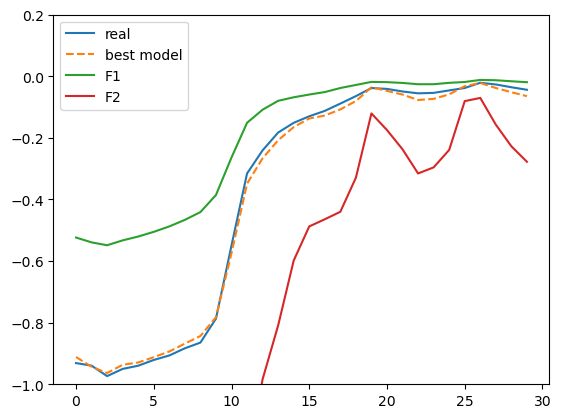

In [36]:
plt.plot(F_obs, label='real')
plt.plot(b1_mean*F1 + b2_mean*F2 + b4_mean*F4, ls='dashed', label='best model')
plt.plot(F1,label='F1')
plt.plot(F2,label='F2')
plt.legend()
plt.ylim(-1,0.2)

## pruebo como queda con un perfil individual

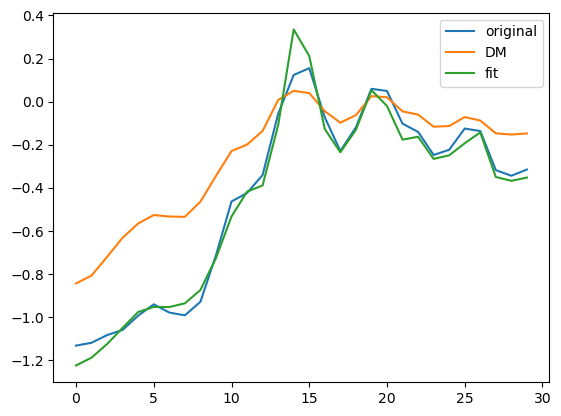

In [29]:
b1 = b1_mean
b2 = b2_mean
b4 = b4_mean

i = 27
plt.plot(f0[i,:], label='original')
plt.plot(f1[i,:], label='DM')
plt.plot(b1*f1[i,:]+b2*f2[i,:]+f4[i,:], label='fit')
plt.legend()

In [37]:
print(b1,b2,b4)

1.058848841113682 0.15426919673332734 -1.0029563891996598


(0.5, 1.5)

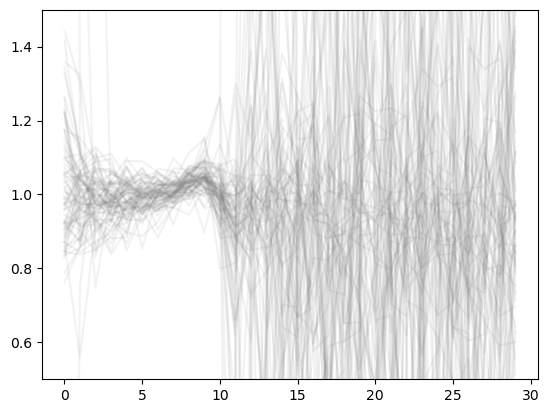

In [57]:
b1 = 1.36
b2 = 0.1
b4 = -1

for i in range(80):
    plt.plot(f0[i,:]/(b1*f1[i,:]+b2*f2[i,:]+f4[i,:]), color='grey',alpha=.1)
#plt.plot(b1*f1[0,:]+b2*f2[0,:]+f4[0,:])
plt.ylim(0.5,1.5)

In [41]:
asd = np.load('/mnt/projects/bias_mock/galaxies/mask_5e-04.npy')

In [42]:
sel, = np.where(asd==True)
len(sel)

1492986